In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

sns.set_style('darkgrid')

In [2]:
# Create an empty DataFrame
df = pd.DataFrame(columns=['path','label'])

#loop over fire images and label them 1
for dirname, _, filenames in os.walk('./fire_dataset/fire'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))

#loop over non fire images and label them 0
for dirname, _, filenames in os.walk('./fire_dataset/no_fire/'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
        #print(os.path.join(dirname, filename))

#shuffle the dataset for redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

path     label
0          ./fire_dataset/fire/fire.24.png      fire
1    ./fire_dataset/no_fire/non_fire.5.png  non_fire
2           ./fire_dataset/fire/fire.7.png      fire
3         ./fire_dataset/fire/fire.149.png      fire
4   ./fire_dataset/no_fire/non_fire.69.png  non_fire
5  ./fire_dataset/no_fire/non_fire.126.png  non_fire
6  ./fire_dataset/no_fire/non_fire.141.png  non_fire
7         ./fire_dataset/fire/fire.151.png      fire
8   ./fire_dataset/no_fire/non_fire.50.png  non_fire
9         ./fire_dataset/fire/fire.137.png      fire

In [3]:
# Data shuffled, let's show the distribution
fig = px.scatter(data_frame = df,x=df.index,y='label',color='label',title='Distribution of fire and non-fire images along the length of the dataframe')
fig.update_traces(marker_size=2)

In [4]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])

fig.add_trace(go.Bar(x =df['label'].value_counts().index,y=df['label'].value_counts().to_numpy(),marker_color=['darkorange','green'],showlegend=False),row=1,col=1)

In [5]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

path     label  height  width
0         ./fire_dataset/fire/fire.24.png      fire     240    360
1   ./fire_dataset/no_fire/non_fire.5.png  non_fire     332    590
2          ./fire_dataset/fire/fire.7.png      fire    1339   1873
3        ./fire_dataset/fire/fire.149.png      fire     400    700
4  ./fire_dataset/no_fire/non_fire.69.png  non_fire    1080   1920

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)

In [8]:
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')

Found 256 validated image filenames belonging to 2 classes.
Found 64 validated image filenames belonging to 2 classes.


In [9]:
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key
    
print(class_indices)

{0: 'fire', 1: 'non_fire'}


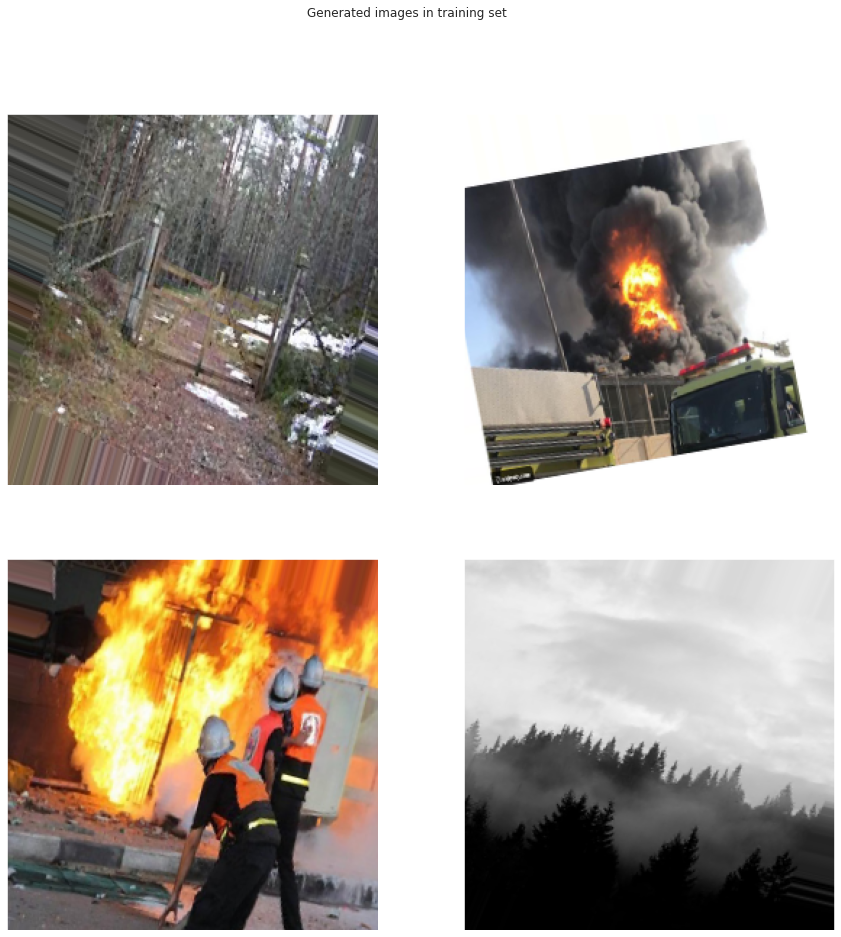

In [10]:
sns.set_style('dark')
pics = 4 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Generated images in training set')
ax = ax.ravel()
for i in range((pics//2)*2):
    ax[i].imshow(train_gen[0][0][i])
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

In [11]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import *
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Recall,AUC
from keras.layers import Dense, Activation, Flatten

In [12]:
#pretrained version of the network
xception = Xception(include_top = False,input_shape = (256,256,3))
input_to_model = xception.input

xception.trainable = False #turn off training


x = Flatten()(xception.output) # flattens the multi-dimensional input tensors into a single dimension so you can model your input layer and build your neural network model
x = Dense(64, activation = 'relu')(x) # each neuron in the dense layer receives input from all neurons of its previous layer (Keep in memory) (units, activation)

output_to_model = Dense(1, activation = 'sigmoid')(x) # sigmoid => The function takes any real value as input and outputs values in the range 0 to 1
model = Model(inputs = input_to_model, outputs = output_to_model)

In [13]:
#Compile the model (defines the loss function, the optimizer and the metrics)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', Recall(), AUC()])

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True) # early_stoppping => With this, the metric to be monitored would be 'loss', and mode would be 'min'
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5) # reduce_lr_on_plateau => Reduce learning rate when a metric has stopped improving.

#Fitting the model (Train it)
model.fit(x = train_gen, batch_size=32, epochs=15, callbacks = [early_stoppping, reduce_lr_on_plateau], validation_data = val_gen)

Epoch 1/15
8/8 [==============================] - 83s 10s/step - loss: 0.9071 - accuracy: 0.8359 - recall: 0.8125 - auc: 0.9034 - val_loss: 1.1332 - val_accuracy: 0.8125 - val_recall: 0.6562 - val_auc: 0.8799 - lr: 0.0010
Epoch 2/15
8/8 [==============================] - 83s 10s/step - loss: 0.6370 - accuracy: 0.8984 - recall: 0.8906 - auc: 0.9490 - val_loss: 0.3960 - val_accuracy: 0.9531 - val_recall: 0.9062 - val_auc: 0.9517 - lr: 0.0010
Epoch 3/15
8/8 [==============================] - 77s 10s/step - loss: 1.0309 - accuracy: 0.9062 - recall: 0.8906 - auc: 0.9318 - val_loss: 0.2235 - val_accuracy: 0.9688 - val_recall: 0.9375 - val_auc: 0.9678 - lr: 0.0010
Epoch 4/15
8/8 [==============================] - 76s 10s/step - loss: 0.5630 - accuracy: 0.9453 - recall: 0.9375 - auc: 0.9631 - val_loss: 0.1419 - val_accuracy: 0.9688 - val_recall: 1.0000 - val_auc: 0.9976 - lr: 0.0010
Epoch 5/15
8/8 [==============================] - 82s 10s/step - loss: 0.3404 - accuracy: 0.9414 - recall: 0.960

In [15]:
# loss => Loss is the penalty for a bad prediction
# accuracy => Number of correct predictions
# recall => The ratio between the number of Positive samples correctly classified as Positive to the total number of Positive samples
# auc => Area under the ROC Curve

eval_list = model.evaluate(val_gen,return_dict=True)
print(eval_list)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

2/2 [==============================] - 15s 6s/step - loss: 0.4963 - accuracy: 0.9531 - recall: 0.9375 - auc: 0.9502
{'loss': 0.4962574243545532, 'accuracy': 0.953125, 'recall': 0.9375, 'auc': 0.9501953125}
loss: 0.50
accuracy: 0.95
recall: 0.94
auc: 0.95


In [16]:
from google.colab import files

uploaded = files.upload();
name = list(uploaded.keys())[0]

Saving aptopix_france_notre_dame_fire_87705-jpg-8a639-2560x1759.jpeg to aptopix_france_notre_dame_fire_87705-jpg-8a639-2560x1759 (4).jpeg


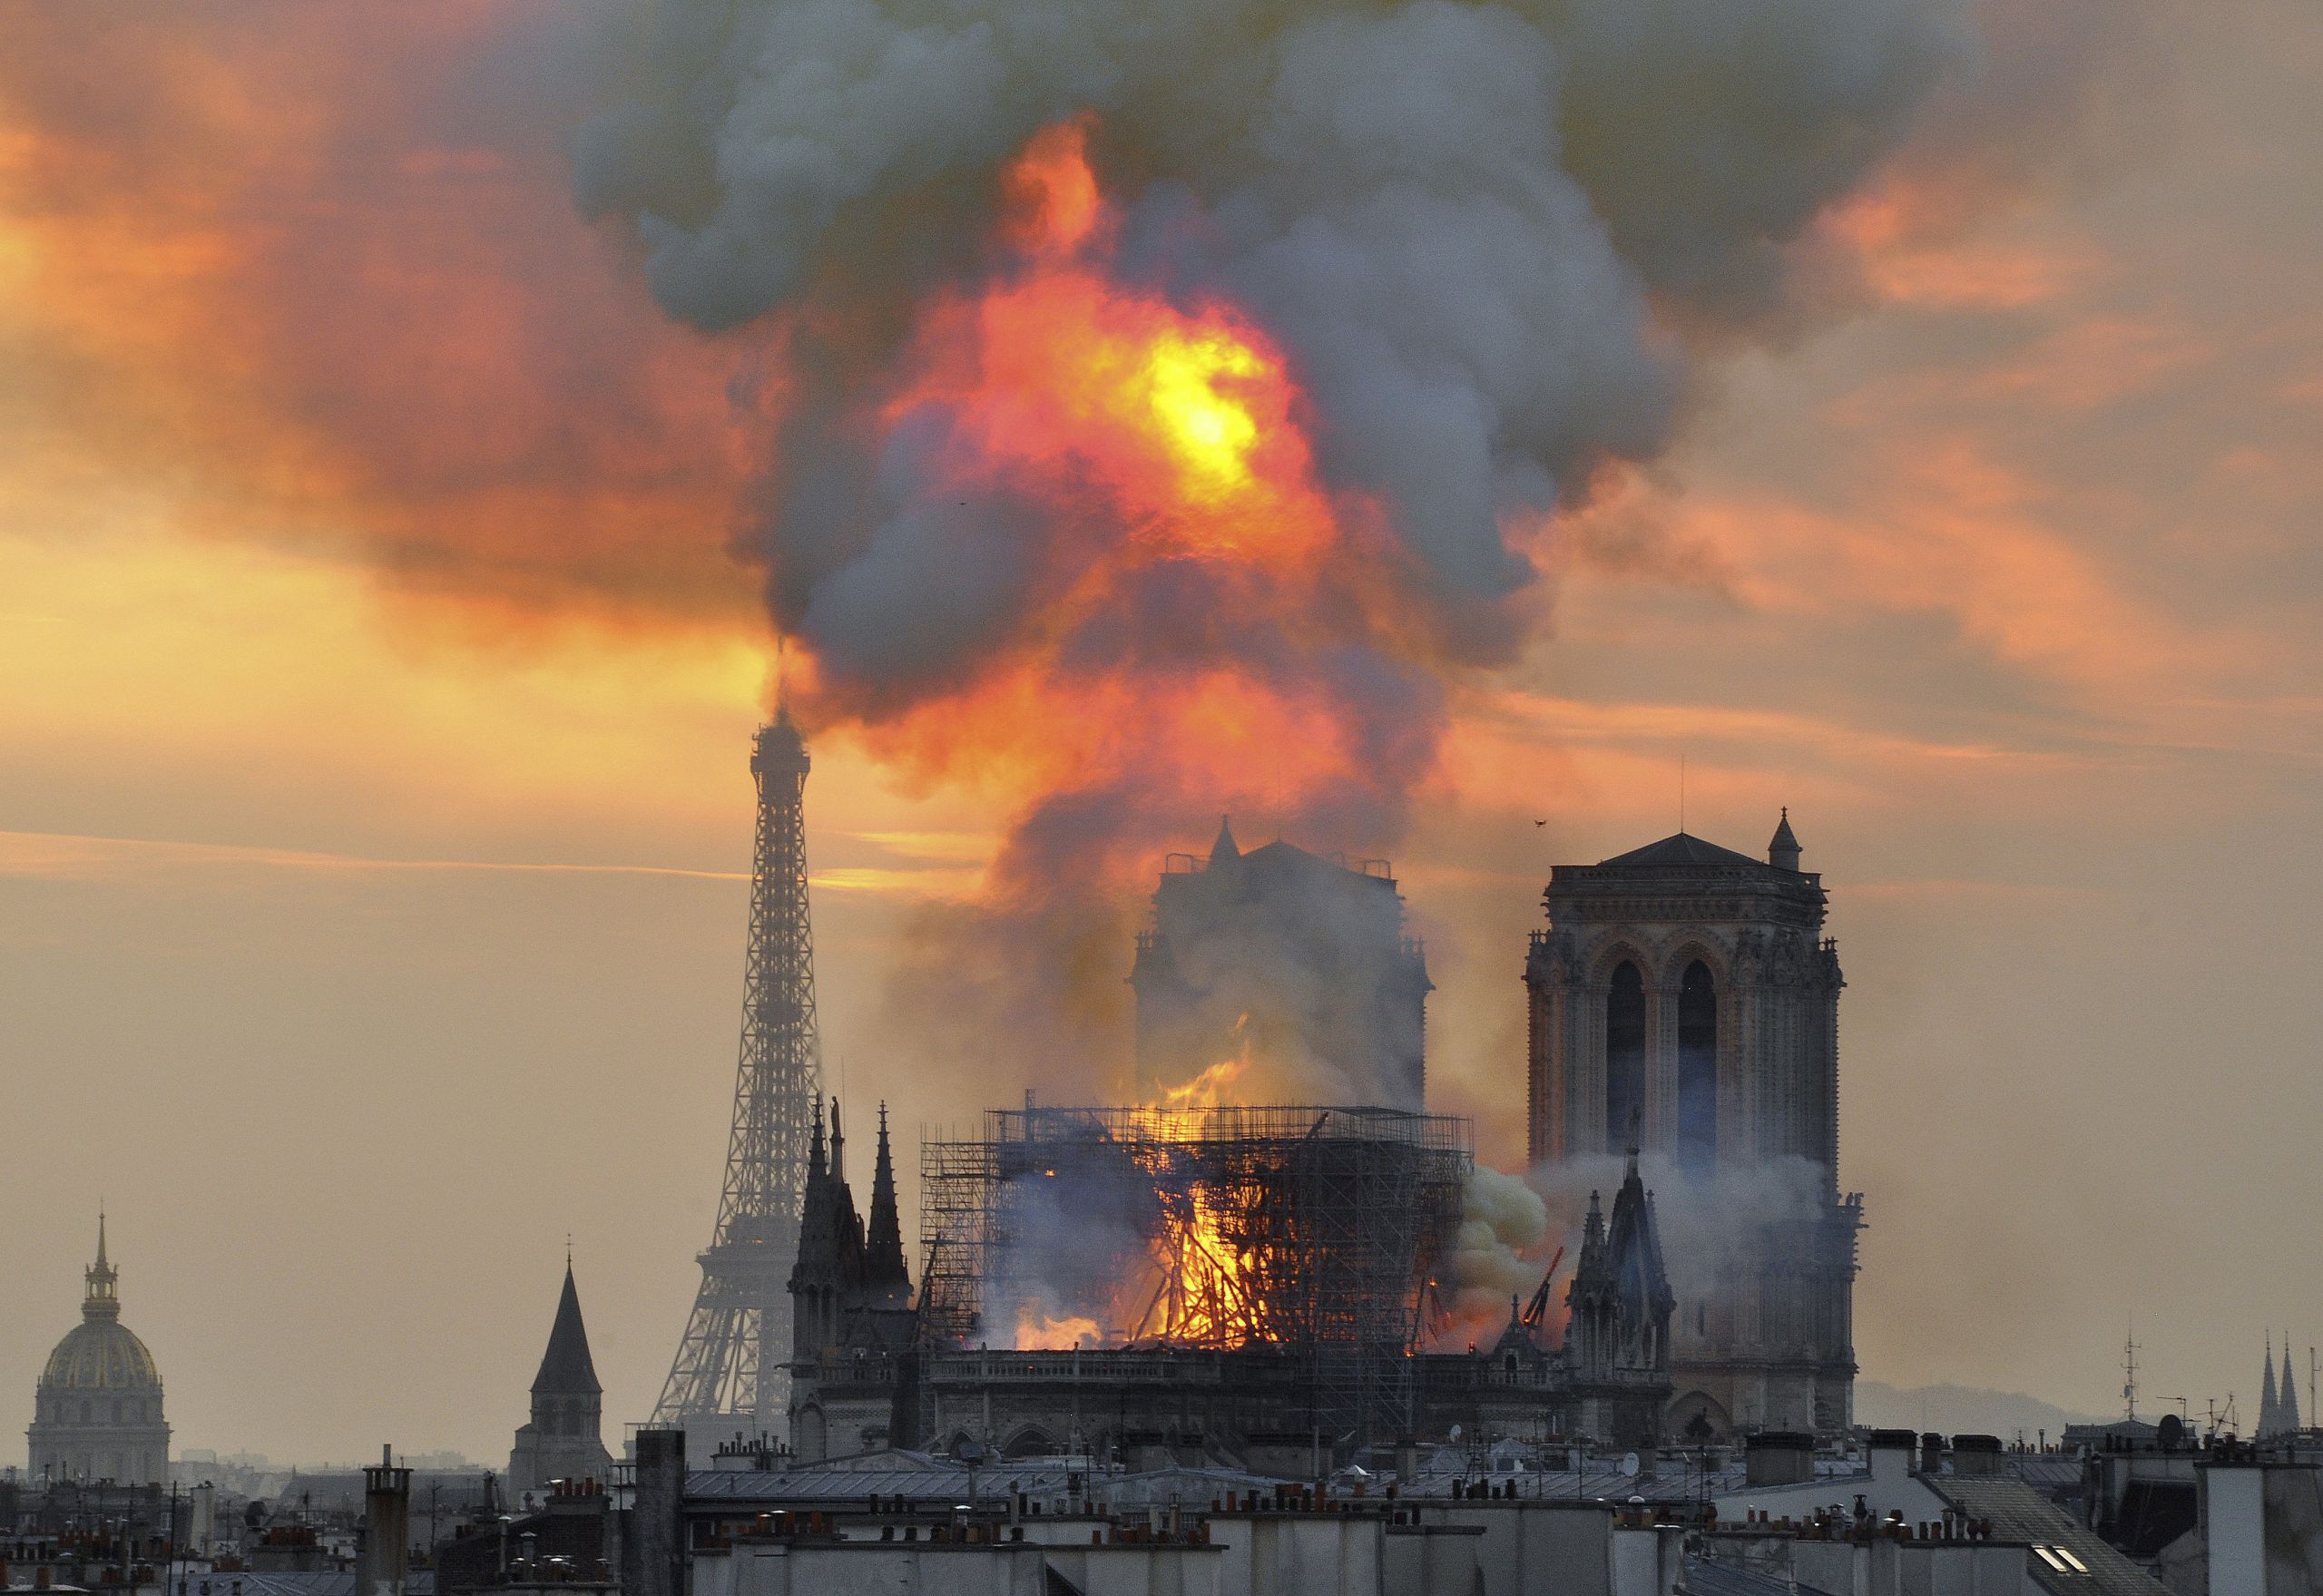

In [17]:
img = image.load_img(name)
img

In [18]:
img = image.load_img(name)

# Resize image
img = image.img_to_array(img)/255
img = tf.image.resize(img,(256,256))
img = tf.expand_dims(img,axis=0)

prediction = model.predict(x=img)

classDefined = int(tf.round(prediction).numpy()[0][0])
# print(classDefined)
print("The predicted value is: ",classDefined,"and the predicted label is:", class_indices[classDefined])

The predicted value is:  0 and the predicted label is: fire
